<a href="https://colab.research.google.com/github/Gamebred94/Machine-Learning/blob/master/Matrix_multiplication_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Matrix multiplication from scratch



In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

!uv pip install -q --system numba-cuda==0.4.0 #cuda fix
# from numba import config
# config.CUDA_ENABLE_PYNVJITLINK = 1

## Get data

In [2]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path("data")
path_data.mkdir(exist_ok=True)
path_gz = (path_data/"mnist.pkl.gz")

In [3]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [4]:
!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 Sep  5 05:12 mnist.pkl.gz


In [5]:
with gzip.open(path_gz, "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")


In [6]:
lst1 = list(x_train[0])
vals = lst1[200:210]
vals, len(lst1), 28*28

([np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.19140625),
  np.float32(0.9296875),
  np.float32(0.98828125),
  np.float32(0.98828125),
  np.float32(0.98828125),
  np.float32(0.98828125),
  np.float32(0.98828125)],
 784,
 784)

In [7]:
def chunks(x, sz):
    for i in range(0, len(x), sz): yield x[i:i+sz]

In [8]:
list(chunks(vals, 5))

[[np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.19140625),
  np.float32(0.9296875)],
 [np.float32(0.98828125),
  np.float32(0.98828125),
  np.float32(0.98828125),
  np.float32(0.98828125),
  np.float32(0.98828125)]]

In [9]:
vals1 = chunks(vals, 5)
vals1

<generator object chunks at 0x79084b0cf2e0>

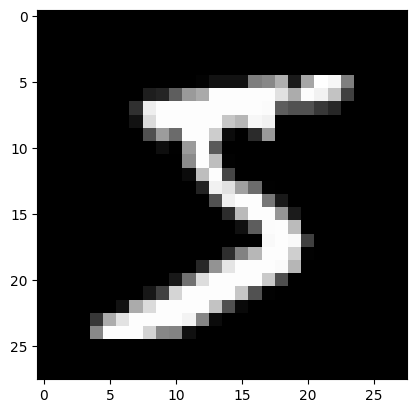

In [10]:
mpl.rcParams["image.cmap"] = "grey"
plt.imshow(list(chunks(lst1, 28)))

[islice](https://docs.python.org/3/library/itertools.html#itertools.islice)

In [11]:
from itertools import islice

In [12]:
it = iter(vals)
it

In [13]:
list(islice(it, 5))

[np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.19140625),
 np.float32(0.9296875)]

In [14]:
list(islice(it, 5))

[np.float32(0.98828125),
 np.float32(0.98828125),
 np.float32(0.98828125),
 np.float32(0.98828125),
 np.float32(0.98828125)]

In [15]:
list(islice(it, 5))

[]

In [16]:
it = iter(lst1)

In [17]:
def f(): return list(islice(it, 28))

In [18]:
f()

[np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0)]

In [19]:
it = iter(lst1)

In [20]:
img = list(iter(lambda: list(islice(it, 28)), []))


In [21]:
len(img), len(img[0])

(28, 28)

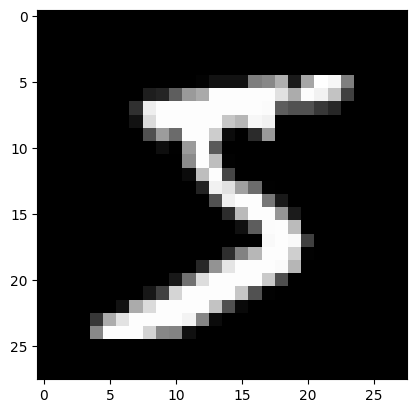

In [22]:
plt.imshow(img)

## Matrix and tensor

In [23]:
img[20][15]

np.float32(0.98828125)

In [24]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [25]:
m = Matrix(img)
m[20,15]

np.float32(0.98828125)

In [26]:
import torch
from torch import tensor

In [27]:
tensor([1,2,3])

tensor([1, 2, 3])

In [28]:
tens = tensor(img)
tens[20,15]

tensor(0.9883)

In [29]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape, x_train.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

In [30]:
x_train.dtype

torch.float32

[Tensor](https://pytorch.org/docs/stable/tensors.html)

In [31]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

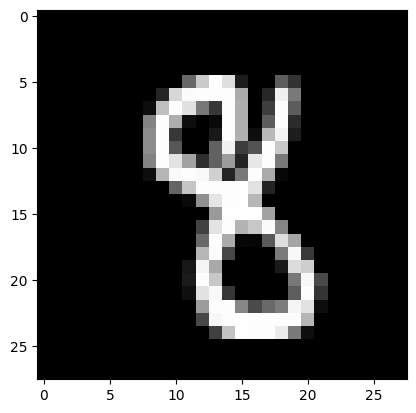

In [32]:
plt.imshow(imgs[-1])

In [33]:
imgs[0,20,15]

tensor(0.9883)

In [34]:
n,c = x_train.shape
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [35]:
min(y_train), max(y_train)

(tensor(0), tensor(9))

In [36]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

## Random numbers

Based on the Wichmann Hill algorithm used before Python 2.3.

In [37]:
num = time.time()
num

1757049173.1338727

In [38]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [39]:
seed(num)
rnd_state

(22042, 27744, 2)

In [40]:
def rand():
    global rnd_state
    x,y,z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [41]:
rand(), rand(), rand()

(0.9883752504081538, 0.45527269331442466, 0.08809402400584343)

In [42]:
# creating a copy and calling rand
if os.fork(): print(f"In parent: {rand()}")
else:
    print(f"In child: {rand()}")
    os._exit(os.EX_OK)

In parent: 0.5480821725502782


In [43]:
if os.fork(): print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.8439])
In child: tensor([0.8439])


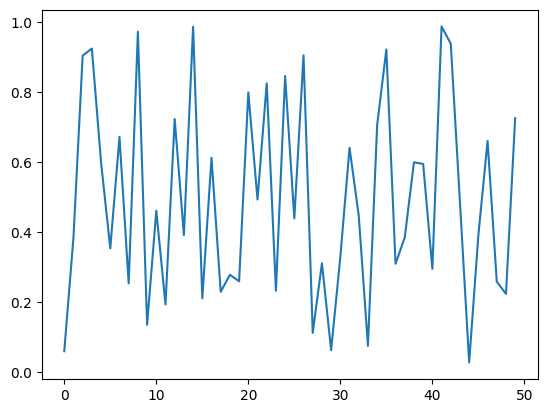

In [44]:
plt.plot([rand() for _ in range(50)])

(array([ 974.,  988.,  977., 1026.,  978.,  965., 1007., 1033., 1032.,
        1020.]),
 array([6.11542943e-05, 1.00045648e-01, 2.00030142e-01, 3.00014635e-01,
        3.99999129e-01, 4.99983623e-01, 5.99968117e-01, 6.99952610e-01,
        7.99937104e-01, 8.99921598e-01, 9.99906091e-01]),
 <BarContainer object of 10 artists>)

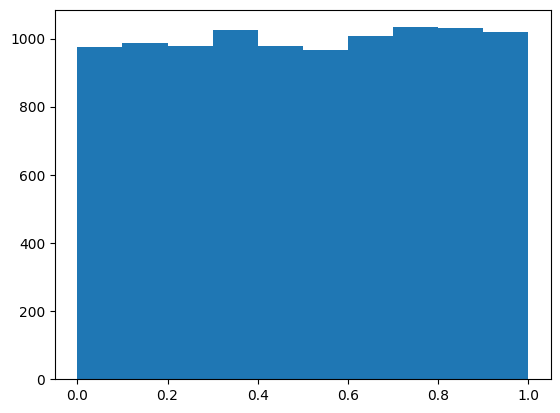

In [45]:
plt.hist([rand() for i in range(10000)])

In [46]:
%timeit  -n 10 list(chunks([rand() for _ in range(7840)], 10))

3.74 ms ± 372 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
%timeit -n 10 torch.randn(784, 10)

The slowest run took 5.45 times longer than the fastest. This could mean that an intermediate result is being cached.
84.2 µs ± 73.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Matrix multiplication

In [48]:
torch.manual_seed(1)
weights = torch.randn(784,10)
bias = torch.zeros(10)

In [49]:
x_valid.shape,weights.shape

(torch.Size([10000, 784]), torch.Size([784, 10]))

In [50]:
m1 = x_valid[:5]
m2 = weights
m1.shape, m2.shape


(torch.Size([5, 784]), torch.Size([784, 10]))

In [51]:
ar,ac = m1.shape
br,bc = m2.shape
(ar,ac), (br,bc)

((5, 784), (784, 10))

In [52]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [53]:
for i in range(ar): #5
    for j in range(bc): #10
        for k in range(br): #784
            t1[i,j] += m1[i,k] * m2[k,j]



In [54]:
t1.shape, t1

(torch.Size([5, 10]),
 tensor([[-10.9417,  -0.6844,  -7.0038,  -4.0066,  -2.0857,  -3.3588,   3.9127,
           -3.4375, -11.4696,  -2.1153],
         [ 14.5430,   5.9977,   2.8914,  -4.0777,   6.5914, -14.7383,  -9.2787,
            2.1577, -15.2772,  -2.6758],
         [  2.2204,  -3.2171,  -4.7988,  -6.0453,  14.1661,  -8.9824,  -4.7922,
           -5.4446, -20.6758,  13.5657],
         [ -6.7097,   8.8998,  -7.4611,  -7.8966,   2.6994,  -4.7260, -11.0278,
          -12.9776,  -6.4443,   3.6376],
         [ -2.4444,  -6.4034,  -2.3984,  -9.0371,  11.1772,  -5.7724,  -8.9214,
           -3.7862,  -8.9827,   5.2797]]))

In [55]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [56]:
def matmult(m1,m2):
  (ar,ac),(br,bc) = m1.shape,m2.shape
  c = torch.zeros(ar, bc)
  for i in range(ar): #5
    for j in range(bc): #10
        for k in range(br): #784
            c[i,j] += m1[i,k] * m2[k,j]

  return c

In [57]:
%time matmult(m1,m2)

CPU times: user 941 ms, sys: 11 ms, total: 952 ms
Wall time: 976 ms


tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [58]:
ar*bc*ac

39200

## Numba

In [59]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)

In [60]:
from numpy import array
from numba import njit
njit

<function numba.core.decorators.njit(*args, **kws)>

In [61]:
@njit
def dot(a,b):
    res = 0.
    for i in range(len(a)): res+=a[i]*b[i]
    return res

In [62]:
%time dot

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


CPUDispatcher(<function dot at 0x79081cac16c0>)

In [63]:
%time dot(array([1.,2,3]), array([2.,3,4]))

CPU times: user 1.15 s, sys: 101 ms, total: 1.25 s
Wall time: 2.35 s


20.0

In [64]:
%time dot(array([1.,2,3]), array([2.,3,4]))

CPU times: user 28 µs, sys: 5 µs, total: 33 µs
Wall time: 37.7 µs


20.0

Now only two of our loops are running in Python, not three:

In [65]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = dot(a[i,:], b[:,j])
    return c


In [66]:
m1a,m2a = m1.numpy(),m2.numpy()

In [67]:
from fastcore.test import *

In [68]:
test_close(t1,matmul(m1a, m2a))

In [69]:
%timeit -n 50 matmul(m1a,m2a)

665 µs ± 67.6 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Elementwise ops

[TryAPL](https://tryapl.org/)

In [70]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [71]:
a + b, a<b

(tensor([12., 14.,  3.]), tensor([False,  True,  True]))

In [72]:
(a < b).float().mean()

tensor(0.67)

In [73]:
m = tensor([[1,2,3], [4,5,6], [7,8,9]])
m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste. This is the source LaTeX that I pasted to render the equation above:

```latex
$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$
```

In [74]:
sf = (m*m).sum()
sf

tensor(285)

In [75]:
sf.sqrt()

tensor(16.88)

In [76]:
m[2, :], m[:,2], m[2]

(tensor([7, 8, 9]), tensor([3, 6, 9]), tensor([7, 8, 9]))

In [77]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = (a[i,:] * b[:,j]).sum()
    return c



In [78]:
test_close(t1,matmul(m1, m2))

In [79]:
%timeit -n 50 _=matmul(m1, m2)

1.82 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [80]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = torch.dot(a[i,:], b[:,j])
    return c


In [81]:
test_close(t1,matmul(m1, m2))

In [82]:
%timeit -n 50 _=matmul(m1,m2)

2.01 ms ± 777 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with
    different shapes during arithmetic operations. Subject to certain
    constraints, the smaller array is “broadcast” across the larger
    array so that they have compatible shapes. Broadcasting provides a
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

### Broadcasting with a scalar

In [83]:
a = tensor([10.,  6., -4.])
a > 0


tensor([ True,  True, False])

How are we able to do `a > 0`?  0 is being **broadcast** to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

In [84]:
a + 1

tensor([11.,  7., -3.])

In [85]:
m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [86]:
2 * m

tensor([[ 2,  4,  6],
        [ 8, 10, 12],
        [14, 16, 18]])

### Broadcasting a vector to a matrix

Although broadcasting a scalar is an idea that dates back to APL, the more powerful idea of broadcasting across higher rank tensors [comes from](https://mail.python.org/pipermail/matrix-sig/1995-November/000143.html) a little known language called [Yorick](https://software.llnl.gov/yorick-doc/manual/yorick_50.html).

We can also broadcast a vector to a matrix:

In [87]:
c = tensor([10.,20,30])
c,m

(tensor([10., 20., 30.]),
 tensor([[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]))

In [88]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [89]:
m + c, c + m

(tensor([[11., 22., 33.],
         [14., 25., 36.],
         [17., 28., 39.]]),
 tensor([[11., 22., 33.],
         [14., 25., 36.],
         [17., 28., 39.]]))

In [90]:
t = c.expand_as(m)

In [91]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [92]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

In [93]:
t.storage()

/tmp/ipython-input-93-1911556638.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t.storage()


 10.0
 20.0
 30.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 3]

In [94]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [95]:
c.unsqueeze(0), c[None, :]

(tensor([[10., 20., 30.]]), tensor([[10., 20., 30.]]))

In [96]:
c.shape, c.unsqueeze(0).shape

(torch.Size([3]), torch.Size([1, 3]))

In [97]:
c.unsqueeze(1), c[:, None]

(tensor([[10.],
         [20.],
         [30.]]),
 tensor([[10.],
         [20.],
         [30.]]))

In [98]:
c.shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([3, 1]))

You can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

In [99]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [100]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [101]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [102]:
m + c[None,:]

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

### Broadcasting Rules

In [103]:
c[None, :], c[None, :].shape

(tensor([[10., 20., 30.]]), torch.Size([1, 3]))

In [104]:
c[:,None], c[:,None].shape

(tensor([[10.],
         [20.],
         [30.]]),
 torch.Size([3, 1]))

In [105]:
c[None, :] * c[:, None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [106]:
c[None] > c[:, None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [107]:
m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [108]:
m*m

tensor([[ 1,  4,  9],
        [16, 25, 36],
        [49, 64, 81]])

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

## Matmul with broadcasting

In [109]:
digit = m1[0]
digit.shape, m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [110]:
digit[:,None].shape, digit[:,None].expand_as(m2).shape

(torch.Size([784, 1]), torch.Size([784, 10]))

In [111]:
(digit[:,None] * m2).shape

torch.Size([784, 10])

In [112]:
(digit[:,None]*m2).shape, (digit[:,None]*m2).sum(dim=0).shape

(torch.Size([784, 10]), torch.Size([10]))

In [113]:
(digit[:,None]*m2).shape, (digit[:,None]*m2).sum(dim=0).shape

(torch.Size([784, 10]), torch.Size([10]))

In [114]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar,bc)
    for i in range(ar):
      # for j in range(bc):
        # c[i,j] = (a[i,:] * b[:,j]).sum()      # previous version
        c[i] = (a[i,:,None] * b).sum(dim=0) # broadcast version
    return c

In [115]:
test_close(t1, matmul(m1,m2))

In [116]:
%timeit -n 50 _= matmul(m1,m2)

241 µs ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


Our time has gone from ~500ms to <0.1ms, an over 5000x improvement! We can run on the whole dataset now.

In [117]:
tr = matmul(x_train, weights)
tr, tr.shape

(tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
         [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
         [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
         ...,
         [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
         [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
         [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]]),
 torch.Size([50000, 10]))

In [118]:
%time _ = matmul(x_train, weights)

CPU times: user 1.4 s, sys: 4.6 ms, total: 1.41 s
Wall time: 1.41 s


## Einstein summation

[Einstein summation](https://ajcr.net/Basic-guide-to-einsum/) ([`einsum`](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html)) is a compact representation for combining products and sums in a general way. The key rules are:

- Repeating letters between input arrays means that values along those axes will be multiplied together.
- Omitting a letter from the output means that values along that axis will be summed.

In [119]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [120]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
mr = torch.einsum('ik,kj->ikj', m1, m2)
mr.shape

torch.Size([5, 784, 10])

In [121]:
mr.sum(1)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [122]:
torch.einsum('ik,kj->ij', m1, m2)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [123]:
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [124]:
test_close(tr, matmul(x_train, weights), eps=1e-3)

In [125]:
%timeit -n 5 _= matmul(x_train, weights)

22.1 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## pytorch op

We can use pytorch's function or operator directly for matrix multiplication.

In [126]:
test_close(tr, x_train@weights, eps=1e-3)

In [127]:
%timeit -n 5 _= torch.matmul(x_train, weights)

20.3 ms ± 356 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


## CUDA

In [128]:
def matmul(grid, a,b,c):
  i,j = grid
  if i < c.shape[0] and j < c.shape[1]:
     tmp = 0.
     for k in range(a.shape[1]):
       tmp += a[i,k] * b[k,j]
     c[i,j] = tmp

In [129]:
res = torch.zeros(ar, bc)
matmul((0,0), m1, m2, res)
res

tensor([[-10.94,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00]])

In [130]:
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
  for i in range(grid_x):
    for j in range(grid_y):
      kernel((i,j), *args, **kwargs)

In [131]:
res = torch.zeros(ar, bc)
launch_kernel(matmul, ar, bc, m1, m2, res)
res

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [132]:
from numba import cuda

In [133]:
# earlier cpu implementation
# def matmul(grid, a,b,c):
#     i,j = grid
#     if i < c.shape[0] and j < c.shape[1]:
#         tmp = 0.
#         for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
#         c[i,j] = tmp

@cuda.jit
def matmul(a,b,c):
  i,j = cuda.grid(2)
  if i < c.shape[0] and j < c.shape[1]:
    tmp = 0.
    for k in range(a.shape[1]):
      tmp += a[i, k] * b[k, j]
    c[i,j] = tmp

In [134]:
r = np.zeros(tr.shape)
m1g,m2g,rg = map(cuda.to_device, (x_train,weights,r))
r.shape

(50000, 10)

In [135]:
r.shape

(50000, 10)

In [136]:
# Each block is a part of a grid in CUDA
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr/TPB), math.ceil(rc/TPB)) # grid corrdinates
blockspergrid

(3125, 1)

In [142]:
matmul[blockspergrid, (TPB, TPB)](m1g,m2g,rg) #send no of blocks/grid, threads/block in each dimension to cuda kernel
r = rg.copy_to_host()
test_close(tr,r,eps=1e-3)

In [143]:
%%timeit -n 5
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

12.7 ms ± 5.06 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [144]:
#using pytorch instead
m1c,m2c = x_train.cuda(),weights.cuda()
r = (m1c@m2c).cpu()

In [145]:
%timeit -n 5 r = (m1c@m2c).cpu()

2.15 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


Our broadcasting version was >500ms, and our CUDA version is around 2.15ms, which is another 1000x improvement compared to broadcasting. So our total speedup is around 5 million times!